In [0]:
import pandas as pd
import numpy as np

In [4]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
path_img = "/content/gdrive/My Drive/profile_display_images_concat_np.npy"
path_df = "/content/gdrive/My Drive/InstagramDatasetRegression.csv"
Regression_data = pd.read_csv(path_df, encoding='utf-8-sig')
image_data = np.load(path_img, allow_pickle=True)

In [6]:
from sklearn.preprocessing import MinMaxScaler
continuous = ["edge_felix_video_timeline", "edge_follow", "edge_followed_by", "edge_owner_to_timeline_media", "highlight_reel_count", "time_between", "hour_of_day", "hr_sin", "hr_cos", "mean_likes", "mean_comments"]
 
# performin min-max scaling each continuous feature column to
# the range [0, 1]
cs = MinMaxScaler()
Data_Continuous = cs.fit_transform(Regression_data[continuous])

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [0]:
Data_Continuous_df = pd.DataFrame(Data_Continuous, columns=continuous)

In [0]:
Regression_data_continuous = Regression_data.drop(continuous,axis=1)

In [0]:
Regression_data_continuous = pd.concat([Regression_data_continuous, Data_Continuous_df], axis = 1)

In [10]:
print(image_data.shape)
image_data = image_data.reshape(20668, 128, 200, 3)
print(image_data.shape)

(20668, 76800)
(20668, 128, 200, 3)


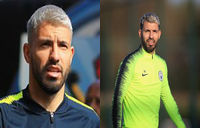

In [9]:
from PIL import Image
img = Image.fromarray(image_data[13])
img

In [10]:
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Dropout
from keras.layers.core import Dense
from keras.layers import Flatten
from keras.layers import Input
from keras.models import Model
 

# define our MLP network
model1 = Sequential()
model1.add(Dense(64, input_dim=46, activation="relu"))
model1.add(Dense(32, activation="relu"))
model1.add(Dense(16, activation="relu"))
model1.add(Dense(8, activation="relu"))
model1.add(Dense(4, activation="relu"))
#model1.add(Dense(1, activation="linear"))
#opt = Adam(lr=1e-4, decay=1e-4 / 200)
#model1.compile(loss="mean_squared_error", optimizer=opt)

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.


In [11]:
from keras import models, optimizers
import keras.layers
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.core import Flatten
from keras.layers.core import Dense
from keras.layers.core import Dropout

model = models.Sequential()
model.add(Conv2D(16, kernel_size=(3, 3), input_shape=(128, 200, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(1250, activation='relu'))
model.add(Dropout(.5))
model.add(Dense(250, activation='relu'))
model.add(Dropout(.25))
model.add(Dense(25, activation='relu'))
model.add(Dense(4, activation = 'relu'))
#model.add(Dense(1, activation="linear"))
#model.compile(optimizer=optimizers.Adam(lr=1e-04, decay = 1e-04/200), loss='mean_squared_error')

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [0]:
from sklearn.model_selection import train_test_split
split = train_test_split(Regression_data_continuous, image_data, test_size=0.25, random_state=42)
(trainAttrX, testAttrX, trainImagesX, testImagesX) = split
trainX = trainAttrX.drop('number_of_likes/mean', axis = 1).values
testX = testAttrX.drop('number_of_likes/mean', axis = 1).values
maxPrice = Regression_data_continuous["number_of_likes/mean"].max()
trainY = trainAttrX["number_of_likes/mean"]/ maxPrice
testY = testAttrX["number_of_likes/mean"]/ maxPrice


In [0]:
from keras.layers import concatenate
combinedInput = concatenate([model1.output, model.output])

In [0]:
x = Dense(4, activation="relu")(combinedInput)
x = Dense(1, activation="linear")(x)
 
# our final model will accept categorical/numerical data on the MLP
# input and images on the CNN input, outputting a single value (the
# predicted price of the house)
model2 = Model(inputs=[model1.input, model.input], outputs=x)
 
# our final model will accept categorical/numerical data on the MLP
# input and images on the CNN input, outputting a single value (the
# predicted price of the house)
opt = Adam(lr=1e-4, decay=1e-4 / 200)
model2.compile(loss="mean_squared_error", optimizer=opt)

 


In [19]:
model2.fit([trainX, trainImagesX], trainY,validation_data=([testX, testImagesX], testY),
	epochs=100, batch_size=8)

Train on 15501 samples, validate on 5167 samples
Epoch 1/100
15501/15501 [==============================] - 38s 2ms/step - loss: 0.0108 - val_loss: 0.0072
Epoch 2/100
15501/15501 [==============================] - 37s 2ms/step - loss: 0.0075 - val_loss: 0.0071
Epoch 3/100
15501/15501 [==============================] - 37s 2ms/step - loss: 0.0068 - val_loss: 0.0071
Epoch 4/100
15501/15501 [==============================] - 36s 2ms/step - loss: 0.0067 - val_loss: 0.0071
Epoch 5/100
15501/15501 [==============================] - 36s 2ms/step - loss: 0.0067 - val_loss: 0.0072
Epoch 6/100
15501/15501 [==============================] - 36s 2ms/step - loss: 0.0067 - val_loss: 0.0071
Epoch 7/100
15501/15501 [==============================] - 37s 2ms/step - loss: 0.0067 - val_loss: 0.0072
Epoch 8/100
15501/15501 [==============================] - 36s 2ms/step - loss: 0.0067 - val_loss: 0.0071
Epoch 9/100
15501/15501 [==============================] - 36s 2ms/step - loss: 0.0067 - val_loss: 0.00

KeyboardInterrupt: ignored

In [20]:
preds = model2.predict([testX, testImagesX])
diff = preds.flatten() - testY
Yitemindex = np.where(testY==0)
print(Yitemindex)
minVal = np.amin(testY[testY != np.amin(testY)])
print(minVal)

(array([ 611,  626, 1418, 2078, 3107]),)
0.008646305557331068


In [0]:
np.put(testY, 611, minVal)
np.put(testY, 626, minVal)
np.put(testY, 1418, minVal)
np.put(testY, 2078, minVal)
np.put(testY, 3107, minVal)

In [22]:
percentDiff = (diff / testY) * 100

absPercentDiff = np.abs(percentDiff)
mean = np.mean(absPercentDiff)
std = np.std(absPercentDiff)
import locale
locale.setlocale(locale.LC_ALL, "en_US.UTF-8")
print("avg likes/mean:")
print(Regression_data_continuous["number_of_likes/mean"].mean())
print("std likes/mean:")
print(Regression_data_continuous["number_of_likes/mean"].std())
print("mean absolute percentage difference: {:.2f}%, std absolute percentage difference.: {:.2f}%".format(mean, std))

avg likes/mean:
1.0000000000000009
std likes/mean:
0.5068692569675557
mean absolute percentage difference: 52.46%, std absolute percentage difference.: 117.06%


In [0]:
maxPrice = Regression_data_continuous["number_of_likes/mean"].max()
yVal = Regression_data_continuous["number_of_likes/mean"]/ maxPrice

In [0]:
Regression_full = Regression_data_continuous.drop('number_of_likes/mean', axis = 1).values

In [25]:
preds_full = model2.predict([Regression_full, image_data])
diff1 = preds_full.flatten() - yVal
Yitemindex = np.where(yVal==0)
print(Yitemindex)
minVal = np.amin(yVal[yVal != np.amin(yVal)])
print(minVal)

(array([ 1200,  1201,  1202,  1203,  8673,  8678, 18779]),)
0.0012154466092707831


In [27]:
np.put(yVal, 1200, minVal)
np.put(yVal, 1201, minVal)
np.put(yVal, 1202, minVal)
np.put(yVal, 1203, minVal)
np.put(yVal, 8673, minVal)
np.put(yVal, 8678, minVal)
np.put(yVal, 18779, minVal)

percentDiff1 = (diff1 / yVal) * 100

absPercentDiff1 = np.abs(percentDiff1)
mean1 = np.mean(absPercentDiff1)
std1 = np.std(absPercentDiff1)
 
import locale
locale.setlocale(locale.LC_ALL, "en_US.UTF-8")
print("avg likes/mean:")
print(Regression_data_continuous["number_of_likes/mean"].mean())
print("std likes/mean:")
print(Regression_data_continuous["number_of_likes/mean"].std())
print("mean absolute percentage difference: {:.2f}%, std absolute percentage difference.: {:.2f}%".format(mean1, std1))

avg likes/mean:
1.0000000000000009
std likes/mean:
0.5068692569675557
mean absolute percentage difference: 55.62%, std absolute percentage difference.: 296.53%


In [28]:
from sklearn import metrics
print(np.sqrt(metrics.mean_squared_error(testY, preds)))
print(np.sqrt(metrics.mean_squared_error(yVal, preds_full)))

0.08598979621767658
0.08121022361661288


In [29]:
print(metrics.r2_score(testY, preds))
print(metrics.r2_score(yVal, preds_full))

0.004947018581887286
0.07968147453575858


In [0]:
preds_full = preds_full.reshape((20668,))

In [0]:
Y1 = Regression_data_continuous["number_of_likes/mean"]
preds_full = preds_full * maxPrice

In [32]:
compare = pd.DataFrame({'Prediction': preds_full, 'Actual' : Y1})
compare.head(23)

,Prediction,Actual
0,0.976086,0.697678
1,0.953590,1.132276
2,0.980276,0.641902
3,1.071517,1.072790
4,0.964933,1.059753
5,1.002403,1.177626
6,0.996506,1.101678
7,0.965483,1.154272
8,1.017332,1.012914
9,1.047986,1.057489


In [0]:
Small_difference = abs((Regression_data_continuous["number_of_likes/mean"].values) - preds_full)  < 0.05
med_difference = abs((Regression_data_continuous["number_of_likes/mean"].values) - preds_full)  < 0.25
Big_difference = abs((Regression_data_continuous["number_of_likes/mean"].values) - preds_full)  > 0.5

In [34]:
Regression_data_continuous[Small_difference].shape[0]

2232

In [35]:
Regression_data_continuous[med_difference].shape[0]

10242

In [36]:
idx_vals = Regression_data_continuous[Small_difference].index.values
idx_big_vals = Regression_data_continuous[Big_difference].index.values
compare1 = compare.ix[idx_vals]
compare2 = compare.ix[idx_big_vals]
compare1.head(10)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  after removing the cwd from sys.path.


,Prediction,Actual
3,1.071517,1.072790
8,1.017332,1.012914
9,1.047986,1.057489
18,0.973511,0.963547
19,0.950904,0.955169
40,0.984849,0.958649
41,0.916406,0.936587
46,0.961216,0.979036
47,0.778364,0.749260
52,0.754215,0.722908


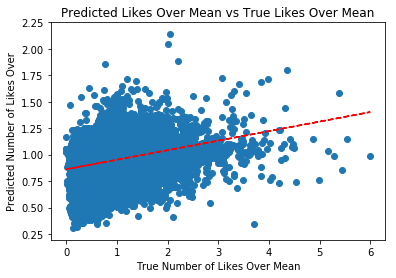

In [37]:
from  matplotlib import pyplot 
pyplot.scatter(Regression_data_continuous["number_of_likes/mean"].values, preds_full)
z = np.polyfit(Regression_data_continuous["number_of_likes/mean"].values, preds_full, 1)
p = np.poly1d(z)
pyplot.plot(Regression_data_continuous["number_of_likes/mean"].values,p(Regression_data_continuous["number_of_likes/mean"].values),"r--")
pyplot.title("Predicted Likes Over Mean vs True Likes Over Mean")
pyplot.xlabel("True Number of Likes Over Mean")
pyplot.ylabel("Predicted Number of Likes Over")
pyplot.show()

In [0]:
model2.save("/content/gdrive/My Drive/full_model.h5")

In [5]:
from keras.models import load_model
model3 = load_model('/content/gdrive/My Drive/full_model.h5')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


In [0]:
preds_full1 = model3.predict([Regression_full, image_data])

In [0]:
Y1 = Regression_data_continuous["number_of_likes/mean"]
preds_full1 = preds_full1 * maxPrice

In [17]:
preds_full1 = preds_full1.reshape((20668,))
compare = pd.DataFrame({'Prediction': preds_full1, 'Actual' : Y1})
compare.head(23)

,Prediction,Actual
0,0.976086,0.697678
1,0.953590,1.132276
2,0.980276,0.641902
3,1.071517,1.072790
4,0.964933,1.059753
5,1.002403,1.177626
6,0.996506,1.101678
7,0.965483,1.154272
8,1.017332,1.012914
9,1.047986,1.057489


In [0]:
def f(compare):
    if (compare['Prediction'] >= 1) & (compare['Actual']>=1):
        val = 1
    elif (compare['Prediction'] <1) & (compare['Actual'] < 1):
        val = 1
    else:
        val = 0
    return val

In [0]:
compare['Val'] = compare.apply(f, axis=1)

In [22]:
compare['Val'].value_counts()

1    12246
0     8422
Name: Val, dtype: int64

In [6]:
model3.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
conv2d_1_input (InputLayer)     (None, 128, 200, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 126, 198, 16) 448         conv2d_1_input[0][0]             
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 63, 99, 16)   0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 61, 97, 32)   4640        max_pooling2d_1[0][0]            
__________________________________________________________________________________________________
max_poolin

In [0]:
from keras.utils import plot_model
plot_model(model3, show_shapes = True, to_file='/content/gdrive/My Drive/model.png')